# Foundations of Linear Regression

## Exercise 1: Understanding the Likelihood of Observations Under a Given Gaussian Model 

### Question 1a: Gaussian Likelihood Function
Write a function to compute the likelihood of observing a set of values under a normal distribution with mean mu and variance sigma^2. The function should accept an observation Y, a mean value mu, and a standard deviation sigma, and return the likelihood of observing Y under these parameters.

In [1]:
import math

# The likelihood of y given mu and sigma
def normal_pdf(y, mu, sigma):
    factor_pi = 1 / math.sqrt(2 * math.pi * (sigma**2))
    factor_exp = math.exp((-1 / (2 * sigma**2)) * (y - mu)**2)
    return factor_pi * factor_exp

### Question 1b: Likelihood Under Standard Normal Model
Simulate a sequence of values from -5 to 5 (with a step of 0.1) and calculate the likelihood of each value under a Standard Normal model (mu=0, sigma=1). Plot these likelihood values and discuss the shape of the plot.

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

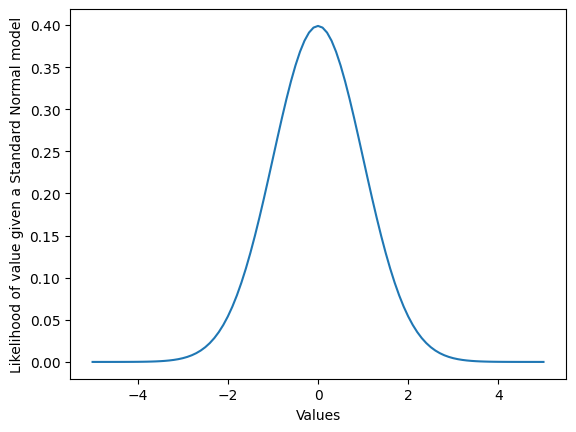

In [3]:
# generate values
values = np.arange(-5, 5.1, 0.1)
# calculate the likelihood for each value
likelihoods = [normal_pdf(value, mu = 0, sigma=1) for value in values]

g = sns.lineplot(x=values, y=likelihoods)
g.set(xlabel="Values", ylabel="Likelihood of value given a Standard Normal model")
plt.show()


This is a normal distribution. What this tells us is that the vast majority of samples drawn from this distribution should sit around 0, with increasingly lower likelihood as values get smaller and bigger. 

## Exercise 2: Playing with Linear Regression

I will be using a dataset that contains data from the municipality of Amsterdam, "clean_tree_data.csv". The data cleaning process is in the municipal_data.ipynb file, annotated for each file I am generating, so I won't be doing the data cleaning again in this file. This dataset is a collection of trees in the Amsterdam area, with information on each tree. 

The goal of the model is to estimate the height of a tree given: its age, its species, the type of soil it is being grown in, the treatment it receives, and the number of parked cars the tree's neighbourhood. (I don't have a strong theoretical basis for a relationship between cars and tree height, but I am interested in the relationship between urban mobility and green public space so I'm just throwing myself a bone!) 

### Question 2a: Linear Regression Model
Estimate a linear regression model to predict tree height using at least one categorical variable (if applicable) and one numeric variable.

Example of categorical variable for this case: tree species.

Example of numeric variable for this case: tree age.

In [4]:
import os

# Change working directory to where you store the Camp files 
os.chdir('/Users/Sari/Documents/Code/Semester 4 workbooks')

In [5]:
import pandas as pd

# load my beautiful tree data
df = pd.read_csv('data/clean_tree_data.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)

#### Tree data

I will give an overview of what I did with my data (it can all be found in municipal_data.ipynb):
1. Tree height was given in estimated ranges (like "between 6 and 9"). I converted these to the average value (so "between 6 and 9" -> 7.5).
2. I converted each tree's "planting year" to its age. Some of the years had typos (i.e. 214 instead of 2014) so I removed any tree that was more than 500 years old.
3. I augmented the data with the number of parked cars per neighbourhood, since the neighbourhood of each tree is in the data. There are about 500 neighbourhoods for Amsterdam.


In [6]:
# There are far many more trees than we need to run our model so I will just
# sample a portion
sample_size = 10000
df_sample = df.sample(frac=1, random_state=31415).iloc[:sample_size]

In [7]:
df_sample.columns

Index(['growth_ground', 'tree_height_fixed', 'tree_height_random',
       'tree_admin', 'tree_municipality', 'age', 'species', 'species_group',
       'tree_treatment', 'Naam_buurt', 'Naam_wijk',
       'parked_cars_in_neighbourhood'],
      dtype='object')

In [8]:
# let's drop all the variables we don't care about here
irrelevant_values = ['tree_height_random', 'tree_admin', 'tree_municipality', 
                     'species_group', 'Naam_buurt', 'Naam_wijk',]
df_relevant = df_sample.drop(irrelevant_values, axis=1)

In [9]:
# let's get the dummies for all our categorical variables
categorical_vars = ['growth_ground', 'species', 'tree_treatment',]

df_dummies = df_relevant.drop(categorical_vars, axis=1)

for category in categorical_vars:
    dummies = pd.get_dummies(df_relevant[category], prefix=category, drop_first=True)
    dummies = dummies.astype(float)
    df_dummies = pd.concat([df_dummies, dummies], axis=1)

In [10]:
# Let's see the results of our effors
display(df_dummies.sample(5))


,tree_height_fixed,age,parked_cars_in_neighbourhood,growth_ground_Bloemrijk gras,growth_ground_Blokhaag,growth_ground_Bodembedekkende heesters,growth_ground_Bodembedekkende rozen,growth_ground_Bomen en struikvormers,growth_ground_Boomvormers,growth_ground_Botanische rozen,...,species_Ulmus minor 'Sarniensis',species_Zelkova serrata,species_Zelkova serrata 'Flekova',tree_treatment_Boom vrij uitgroeiend,tree_treatment_Fruitboom,tree_treatment_Gekandelaberde boom,tree_treatment_Knotboom,tree_treatment_Leiboom,tree_treatment_Stobbe,tree_treatment_Vormboom
51144,16.5,34.0,668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58197,10.5,39.0,771,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
62725,3.0,26.0,2005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27713,16.5,58.0,414,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
15066,21.0,24.0,1421,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Now we estimate the `tree height` regression

In [11]:
import pandas as pd
import statsmodels.api as sm

# 

# Define your design matrix and your target variable 
y_variable = 'tree_height_fixed'
X = df_dummies.drop(y_variable, axis=1)
y = df_dummies[y_variable]

# Add a constant to the features to account for the intercept in the model
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      tree_height_fixed   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.671
Method:                 Least Squares   F-statistic:                     48.03
Date:                Sun, 31 Mar 2024   Prob (F-statistic):               0.00
Time:                        19:58:09   Log-Likelihood:                -25755.
No. Observations:               10000   AIC:                         5.238e+04
Df Residuals:                    9566   BIC:                         5.551e+04
Df Model:                         433                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

### b) Inference by `Empirical Posterior` Simulations

Simulate 1000 values from the empirical posterior distribution of each of your coefficients. Plot the histogram for each of these coefficient simulations, and calculate: i. the proportion of simulation that are above 0; ii. the Monte Carlo Median and 95% prediction interval for each coefficient; iii. Comment on the significance and magnitude of the effects. 

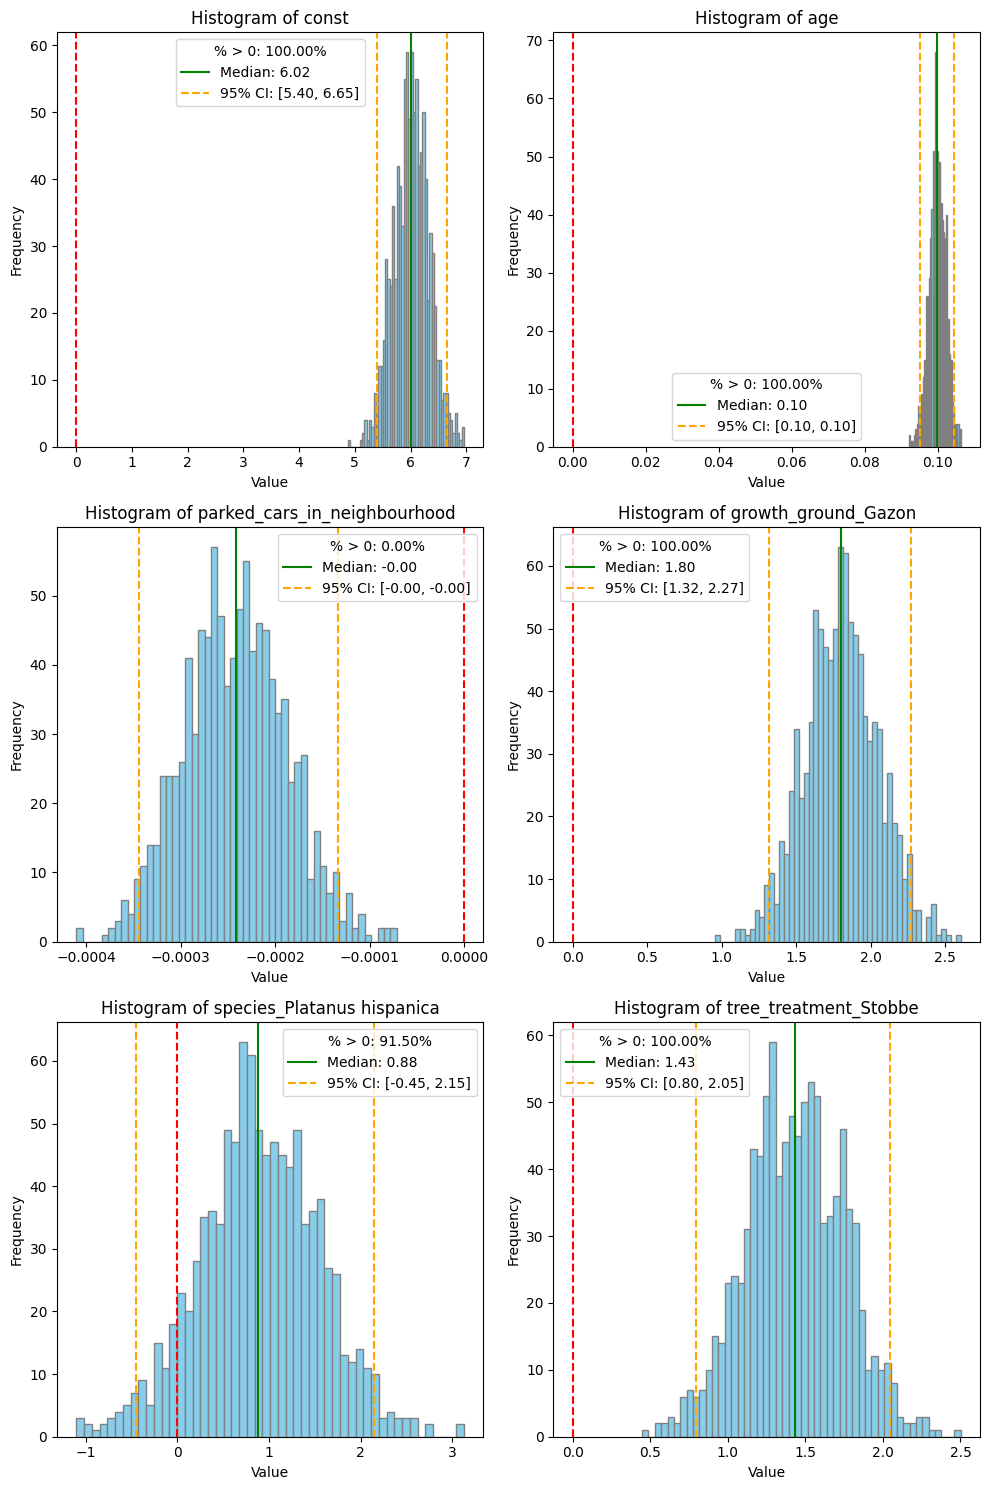

In [12]:
import matplotlib.pyplot as plt

# Simulate values from empirical posterior distribution of model coefficients

# Hint: use the np.random.multivariate_normal function to simulate form a multivariate normal, 
# covariance matrix `cov_params()' from the model. 

simulated_coef_samples = np.random.multivariate_normal(model.params, model.cov_params(), 1000)

# Since I have categorical values, it would be unfeasible to have a plot for
# every single of the coefficients. So I will choose one coefficient for each
# category that's included in my model.

# "Grass" seems like a nice  generic category. And Platanus because they are 
# beautiful huge trees that remind me of Paris. Very scientific reasoning.
parameters_to_plot = ['const',
                      'age', 'parked_cars_in_neighbourhood', 'growth_ground_Gazon',
                      'species_Platanus hispanica', 'tree_treatment_Stobbe']
n_params = len(parameters_to_plot)


# Adjust rows and columns for plotting
n_plots = n_params  # Total number of plots needed
n_rows = 3
n_cols = (n_plots + n_rows - 1) // n_rows  # Calculate columns needed, ensuring we have enough space

# Adjust the figsize if necessary
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5), squeeze=False)  # Make sure axes is always a 2D array

# Flatten axes array for easier iteration
axes_flat = axes.flatten()

for i, name in enumerate(parameters_to_plot):
    mean_val = np.mean(simulated_coef_samples[:, i])
    median_val = np.median(simulated_coef_samples[:, i])
    confidence_interval = np.percentile(simulated_coef_samples[:, i], [2.5, 97.5])
    percent_positive = np.mean(simulated_coef_samples[:, i] > 0) * 100  # Percentage of simulations > 0

    ax = axes_flat[i]
    ax.hist(simulated_coef_samples[:, i], bins=50, color='skyblue', edgecolor='gray')
    ax.axvline(x=median_val, color='green', linestyle='-', label=f'Median: {median_val:.2f}')
    ax.axvline(x=confidence_interval[0], color='orange', linestyle='--', label=f'95% CI: [{confidence_interval[0]:.2f}, {confidence_interval[1]:.2f}]')
    ax.axvline(x=confidence_interval[1], color='orange', linestyle='--')
    ax.axvline(x=0, color='red', linestyle='--')
    ax.set_title(f'Histogram of {name}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.legend(title=f'% > 0: {percent_positive:.2f}%')

# Hide any unused subplots
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes_flat[j])

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


### c) Generate Predicted Values and Estimate Statistics

For each record in your dataset, generate predicted values. Use the package which you are using for fitting the regression model to output a) point estimates for each fitted value; b) the expected standard error of those estimates. Use these to generate 1000 samples from the empirical posterior distribution of the fitted values, and estimate the Monte Carlo Median and the 95% prediction interval.

In [13]:
import statsmodels.api as sm


# Step 1: Prepare the new dataset - remember to add a constant if your model includes an intercept

# X Already has a constant
X_new_with_const = X


# Step 2: Predict new values (use the model.predict function)
new_predictions = model.predict(X_new_with_const)

# Step 3: Calculate standard errors of the predictions
cov_matrix = model.cov_params()
design_matrix = X_new_with_const
variances = np.diag(np.dot(np.dot(design_matrix, cov_matrix), design_matrix.T))
std_errors_predictions = np.sqrt(variances)

# Generate posterior samples
new_predictions_array = np.array(new_predictions)[:, None]  # Convert to numpy array and add new axis
std_errors_predictions_array = np.array(std_errors_predictions)[:, None]  # Convert to numpy array and add new axis

predicted_samples = np.random.normal(loc=new_predictions_array,
                                     scale=std_errors_predictions_array,
                                     size=(len(new_predictions), 1000))

monte_carlo_medians = np.median(predicted_samples, axis=1)
prediction_intervals = np.percentile(predicted_samples, [2.5, 97.5], axis=1)


### d) Plot Observed vs. Predicted Values with Prediction Intervals

Plot the observed values (on the y-axis) against the Monte Carlo Median of the fitted values (x-axis) for each observation. On the same plot, find a way to add the prediction intervals around your fitted values. Make sure the y and x axis span the same support, and add a y = x line to the plot. Comment on what the plot shows - does your model recover good predictions ? How can you tell ? Play around with your model and look how including / removing complexity changes the performance. 

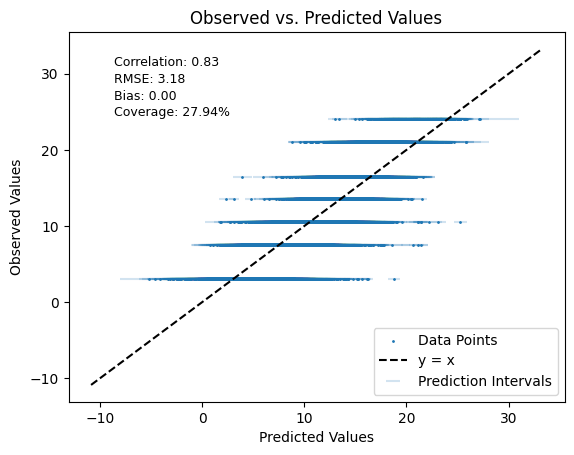

In [14]:
from sklearn.metrics import mean_squared_error



# Calculate metrics
correlation = np.corrcoef(monte_carlo_medians, y)[0, 1]
rmse = np.sqrt(mean_squared_error(y, monte_carlo_medians))
bias = np.mean(monte_carlo_medians - y)  # Mean prediction error
coverage = np.mean((y >= prediction_intervals[0,:]) & (y <= prediction_intervals[1,:]))

# # # Find overall min and max for xlim and ylim

# Flatten predicted_samples to make it 1-dimensional
predicted_samples_flat = predicted_samples.flatten()

# Concatenate the flattened predicted_samples with y
combined_array = np.concatenate([predicted_samples_flat, y])

# calculate min and max
min_val = combined_array.min()
max_val = combined_array.max()

# Plotting
scatter = plt.scatter(monte_carlo_medians, y, s=1, alpha=1, label='Data Points')
errorbar = plt.errorbar(monte_carlo_medians, y, xerr=np.abs(prediction_intervals - monte_carlo_medians), fmt='none', alpha=0.2, label='Prediction Intervals')
y_equals_x = plt.plot([min_val, max_val], [min_val, max_val], 'k--', zorder=3, label='y = x')

# Add legend with metrics
legend_labels = [
    f'Correlation: {correlation:.2f}',
    f'RMSE: {rmse:.2f}',
    f'Bias: {bias:.2f}',
    f'Coverage: {coverage:.2%}'
]

# Add legend for plot elements
plt.legend(loc='lower right')

# Text annotations for metrics
text_x = min_val + (max_val - min_val) * 0.05  # Adjust these positions as necessary
text_y_start = max_val - (max_val - min_val) * 0.05  # Starting y position for text
line_height = (max_val - min_val) * 0.05  # Adjust line height as necessary

for i, label in enumerate(legend_labels):
    plt.text(text_x, text_y_start - i * line_height, label, fontsize=9)



plt.title('Observed vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Observed Values')
plt.show()

That's a very interesting looking graph. Since all the "observed" values are pinned to a few specific values, but our model can predict wider ranges of values, we get these lines. Looking at this makes it a bit more obvious why we should get higher variance on a dataset like this: we can predict a vast range of values even for a category like "between 0 and 6" which is then coverted to a 3.

Something that also jumps out is the capacity for the model to give nonsensical answers: some trees have negative predicted height values.

In some respects the model performs pretty well. It generally predicts higher values for trees which are indeed taller. There is just a lot of variance. Interestingly, it looks like the model systematically overestimates the height of smaller trees, and underestimates the height of taller trees, in such a way that the overall bias cancels out to zero. The huge variance also explains why our coverage is so low - the x = y line only passes through small bits of the horizonal lines. I would expect that if our data contained the actual heights of trees we would also have better coverage. We can imagine that the horizontal lines for the observed data would kind of "join" the x=y line. Any tree that would have a height anywhere between "0 and 6 meters" has been "flattened" into this line. 

I think this also explains the high variance. By necessity, the value of "3" represents a lot of different tree heights, there is going to be high variance around that value. If the heights were more "spread out", the value of "3" would have less variance since it would only represent trees with actual height of 3.